<a href="https://www.kaggle.com/code/limonhalder/binary-segmentation-using-u-net?scriptVersionId=117951005" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Import required libraires

# What is segmentation in deep learning?
Image result for binary segmentation in deep learning
Image segmentation is the task of clustering parts of an image together that belong to the same object class. This process is also called pixel-level classification.
In other words, it involves partitioning images (or video frames) into multiple segments or objects.In binary segmentation there exists two class of object. One object should be detect from others.

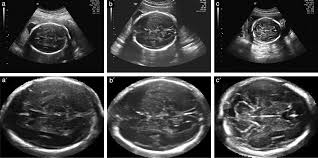

# Import required libraires

In [2]:
import os 
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from keras.preprocessing.image import ImageDataGenerator




img_directory=""
mask_directory=""
size=256
num_img=999



image_names=glob.glob("../input/fetal-head-circumference-data/Fetal Head Circumference/train_set/Images/*.png")

image_names.sort()

print(len(image_names))
image_names_subset=image_names[0:num_img]
images=[cv2.imread(img,0) for img in image_names_subset]
images=[cv2.resize(img,(256,256)) for img in images]
image_dataset=np.array(images)
print(image_dataset.shape)

image_dataset=np.expand_dims(image_dataset, axis=3)



mask_names=glob.glob("../input/fetal-head-circumference-data/Fetal Head Circumference/train_set/Annotation/*.png")

mask_names.sort()
mask_names_subset=mask_names[0:num_img]
masks=[cv2.imread(mask,0) for mask in mask_names_subset]
masks=[cv2.resize(mask,(256,256)) for mask in masks]
mask_dataset=np.array(masks)
mask_dataset=np.expand_dims(mask_dataset, axis=3)




image_dataset=image_dataset/256
mask_dataset=mask_dataset/256


from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(image_dataset,mask_dataset, test_size=.2, random_state=42)

999
(999, 256, 256)


# chenity check

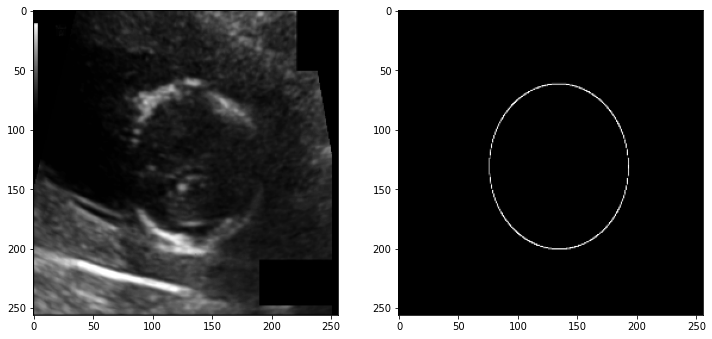

In [3]:
import random
image_number=random.randint(0,len(X_train))
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(X_train[image_number,:,:,0],cmap='gray')
plt.subplot(122)
plt.imshow(y_train[image_number,:,:,0], cmap="gray")
plt.show()

In [11]:
X_train[image_number,:,:,0].shape

(256, 256)

In [3]:
from keras.models import Model
from keras.layers.convolutional import  Conv2D, MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPooling2D, Concatenate,Input, BatchNormalization,Dropout,Lambda


def conv_block(input, num_filters):
    x=Conv2D(num_filters,3,padding="same")(input)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    
    
    x=Conv2D(num_filters,3,padding="same")(x)
    x=BatchNormalization()(x)
    x=Activation("relu")(x)
    return x



def encoder_block(input, num_filters):
    x=conv_block(input,num_filters)
    p=MaxPooling2D((2,2))(x)
    
    return x,p




def decoder_block(input,skip_feature, num_filters):
    x=Conv2DTranspose(num_filters,(2,2),strides=2, padding="same")(input)
    x=Concatenate()([x,skip_feature])
    x=conv_block(x,num_filters)
    return x




def build_unet(input_shape, n_classes):
    inputs=Input(input_shape)
    
    s1,p1=encoder_block(inputs,64)
    s2,p2=encoder_block(p1,128)
    s3,p3=encoder_block(p2,256)
    s4,p4=encoder_block(p3,512)
    
    
    b1=conv_block(p4,1024) # bridge
    
    
    d1=decoder_block(b1,s4,512)
    d2=decoder_block(d1,s3,256)
    d3=decoder_block(d2, s2,128)
    d4=decoder_block(d3,s1,64)
    
    if n_classes==1:
        activation="sigmoid"
        
    else:
        activation="softmax"
    
    
    
    outputs=Conv2D(n_classes,1,padding="same",activation=activation)(d4)
    
    
    model=Model(inputs,outputs,name="U-Net")
    
    return model
    

    
Img_height=image_dataset.shape[1]
Img_width=image_dataset.shape[2]
Img_channel=image_dataset.shape[3]
input_shape=(Img_height,Img_width,Img_channel)




model=build_unet(input_shape,n_classes=1)
model.summary()

2023-02-01 16:49:52.117222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 16:49:52.125427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 16:49:52.126094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 16:49:52.127168: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
#model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error',metrics=["mse"])

In [ ]:
data_gen_args = dict(
    #featurewise_center=True,
                     #featurewise_std_normalization=True,
                     #rotation_range=90,
                     horizontal_flip=True,
                     vertical_flip=True,
                     #width_shift_range=0.1,
                     #height_shift_range=0.1,
                     #zoom_range=0.2
                     fill_mode="reflect"
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

data_gen_arg = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     #rotation_range=90,
                     #width_shift_range=0.1,
                     #height_shift_range=0.1,
                     #zoom_range=0.2
                    )
test_image_datagen = ImageDataGenerator(**data_gen_arg)
test_mask_datagen = ImageDataGenerator(**data_gen_arg)
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
image_datagen.fit(X_train, augment=True, seed=seed)
mask_datagen.fit(y_train, augment=True, seed=seed)
image_generator = image_datagen.flow(
    X_train,
    #class_mode=None,
    seed=seed)
mask_generator = mask_datagen.flow(
    y_train,
    #class_mode=None,
    seed=seed)

image_val = test_image_datagen.flow(
    X_test,
    #class_mode=None,
    seed=seed)
mask_val = test_mask_datagen.flow(
    y_test,
    #class_mode=None,
    seed=seed)


# combine generators into one which yields image and masks
train_generator = zip(image_generator, mask_generator)
val_generator= zip(X_test,y_test)

model.fit(
    train_generator,
    validation_data=val_generator,
    
    steps_per_epoch=200,
    epochs=50)

2023-02-01 16:50:08.592080: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-02-01 16:50:11.020879: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-02-01 16:50:14.432919: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  5/200 [..............................] - ETA: 2:30 - loss: -0.0148 - jacard_coef: 0.0148

2023-02-01 16:50:20.534787: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.38GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


 24/200 [==>...........................] - ETA: 2:15 - loss: -0.0250 - jacard_coef: 0.0250

2023-02-01 16:50:37.723210: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


200/200 [==============================] - ETA: 0s - loss: -0.0878 - jacard_coef: 0.0878

# History

In [5]:
from keras import backend as K
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)  # -1 ultiplied as we want to minimize this value as loss function

# Compile the model with the IoU loss function and metric
model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])


In [1]:

from keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator object
datagen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    #zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Load your data


# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)
X=[]
Y=[]
# Use the ImageDataGenerator to generate augmented images
for X_batch, y_batch in datagen.flow(X_train, y_train,  batch_size=1):
    
    X.append(X_batch)
    Y.append(y_batch)
    
history=model.fit(X,Y,                 batch_size=3,
                 verbose=1,
                 epochs=400,
                 validation_data=(X_test,y_test),
                 shuffle=False)
    
    
    
    

NameError: name 'X_train' is not defined

In [19]:
train=datagen.flow(X_train, y_train)
history=model.fit(train,
       # batch_size=320,
        verbose=1,
        epochs=400,
        validation_data=(X_test,y_test),
        shuffle=False)
    
    


NameError: name 'datagen' is not defined

In [22]:
history=model.fit(X_train,y_train,
                 batch_size=3,
                 verbose=1,
                 epochs=40,
                 validation_data=(X_test,y_test),
                 shuffle=False)



Epoch 1/40
267/267 [==============================] - 29s 110ms/step - loss: -0.2522 - jacard_coef: 0.2523 - val_loss: -0.1271 - val_jacard_coef: 0.1270
Epoch 2/40
 43/267 [===>..........................] - ETA: 22s - loss: -0.2951 - jacard_coef: 0.2951

KeyboardInterrupt: 

In [19]:
s=X_test[8]

In [21]:
model.save("Fetal_model.h5")

In [22]:
predicts=model.predict(X_test)

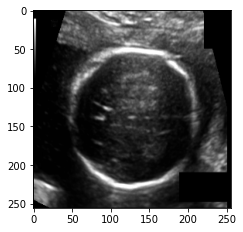

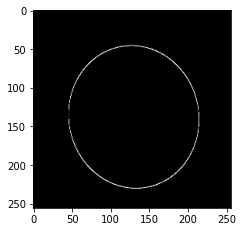

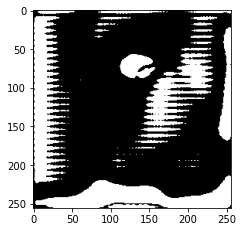

In [7]:
thrshold=0
test_img_number=random.randint(0,len(X_test))
test_img=X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_image_input=np.expand_dims(test_img,0)
predictio=(model.predict(test_image_input)[0,:,:,:]>.15).astype(np.uint8)
#predictio=(model.predict(test_image_input)[0,:,:,:]>.15)


plt.figure(figsize=(16,8))
plt.title("testing Image")
plt.subplot(221)
plt.imshow(test_img[:,:,:],cmap='gray')

plt.figure(figsize=(16,8))
plt.title("true value")
plt.subplot(222)
plt.imshow(ground_truth[:,:,:],cmap='gray')


plt.figure(figsize=(16,8))
plt.title("predicted")
plt.subplot(223)
plt.imshow(predictio,cmap='gray')
plt.show()

In [23]:
pip install pillow

Note: you may need to restart the kernel to use updated packages.


In [24]:
pip install image 


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 16.7 MB/s eta 0:00:0000:0100:01
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19496 sha256=51afc1b49fa2203a25547f50bb32b04b0a883a3ea1934c9dd2db8ab0a2f788b6
  Stored in directory: /root/.cache/pip/wheels/56/88/e6/897194cfe8c08a8b9afd881d3bf53d102e13fa39607d721383
Successfully built image
Note: you may need to restart the kernel to use updated packages.


In [ ]:
predictio.shape

In [25]:
from PIL import Image
import numpy as np

x = predictio

im = Image.fromarray(x[:,:,0])
im.save('pred.png')
image=test_image_input[0,:,:,0].astype(np.uint8)
image = Image.fromarray(image)
image.save("img.png")


In [26]:
os.mkdir('/kaggle/working/image')
os.mkdir('/kaggle/working/predictions')



In [78]:
test_image_input[0,:,:,0].shape

(256, 256)

In [87]:
test_image_input.dtype

dtype('float64')

In [27]:
for i in range(len(X_test)):
    
    test_img_number=i
    test_img=X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_image_input=np.expand_dims(test_img,0)    
    x=(model.predict(test_image_input)[0,:,:,:]>.15).astype(np.uint8)
    im = Image.fromarray(x[:,:,0])
    im.save('/kaggle/working/predictions/pred'+str(i)+'.png')
    image=test_image_input[0,:,:,0].astype(np.uint8)
    image = Image.fromarray(image)
    image.save("/kaggle/working/image/orginal_"+str(i) +".png")
    

In [ ]:
predictio.shape

In [ ]:
plt.imshow(predictio,cmap='gray')

predictio and ground are in different data type. thats why can not be substract

In [ ]:
X_test.shape[0]

# Prediction for whole dataset

In [ ]:
predicts=model.predict(X_test)

In [ ]:
predicts.shape

In [ ]:
predict2=[]
masks=[]

def prediction(image_dataset):
    for i in range(image_dataset.shape[0]):
        test_img=image_dataset[i]
        ground_truth=mask_dataset[i]
        test_image_input=np.expand_dims(test_img,0)
        predict=(model.predict(test_image_input)[0,:,:,:]>.141).astype("float32")
        predict2.append(predict)
        
    return predict2    

In [ ]:
#predicts2=prediction(X_test)

In [ ]:
 predicts= np.array(predicts)

In [ ]:
predicts2.shape

In [ ]:
X_test.shape

In [ ]:
plt.subplot(122),plt.imshow(predicts[3], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(y_test[73], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(predicts[0], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

# MSE error mesurement

# What is MSE error in binary segmentation ?

 Mean-Square Error. MSE value denotes the average difference of the pixels all over the image.

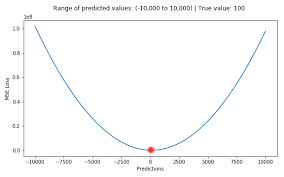

In [ ]:
#img1 = cv2.imread('')
#img2 = cv2.imread(prediction)

# convert the images to grayscale
#
#
#img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# define the function to compute MSE between two images
def mse(img1, img2):
   h, w = img1.shape
   diff = cv2.subtract(img1, img2)
   err = np.sum(diff**2)
   mse = err/(float(h*w))
   return mse



In [ ]:
ERROR1=[]
def MSE(masks, predicts):
  
    masks=[np.asarray(mask, np.float64) for mask in masks]
    masks=[img[:,:,0] for img in masks]
    

    preds=[np.asarray(pred, np.float64) for pred in predicts]
    preds=[img[:,:,0] for img in preds ]
    
    
    
    for mask , pred in zip(masks, preds):
        error=mse(mask,pred)
        ERROR1.append(error)
    return ERROR1

In [ ]:
ERROR2=[]
def MSE2(masks, predicts):
  
    masks=[np.asarray(mask, np.float64) for mask in masks]
    masks=[img[:,:,0] for img in masks]
    

    preds=[np.asarray(pred, np.float64) for pred in predicts]
    preds=[img[:,:,0] for img in preds ]
    
    
    
    for mask , pred in zip(masks, preds):
        error=mse(mask,pred)
        ERROR2.append(error)
    return ERROR2

In [ ]:
#MSE(X_test,y_test)

In [ ]:
error = MSE(y_test,predicts2)
print("Image matching Error between the two images:",error)

# Hough Transform

# What is Hough Transform?
The Hough transform is a feature extraction technique used in image analysis, computer vision, and digital image processing. The purpose of the technique is to find imperfect instances of objects within a certain class of shapes by a voting procedure.

Here we use circle Hough Transform

# How does Hough circle transform work?
Image result for hough transform
The circle Hough Transform (CHT) is a basic feature extraction technique used in digital image processing for detecting circles in imperfect images. The circle candidates are produced by “voting” in the Hough parameter space and then selecting local maxima in an accumulator matrix.

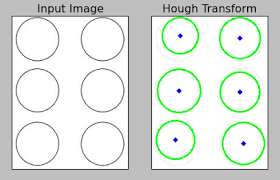

In [ ]:
predicts=model.predict(X_test)

In [ ]:
predicts.shape

In [ ]:
predicts2.dtype

In [ ]:
predicts=predicts*256

In [ ]:
predicts.dtype

In [ ]:
predicts=predicts.astype('uint8')

In [ ]:
predicts.dtype

In [ ]:
bgr_img=predicts[8]
plt.subplot(122),plt.imshow(bgr_img, cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
bgr_img=predicts2[0]
plt.subplot(121),plt.imshow(mask_dataset[9], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
bgr_img=predicts[110]

In [ ]:
if bgr_img.shape[-1] == 3:           # color image
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
else:
    gray_img = bgr_img

img = cv2.medianBlur(gray_img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.subplot(121),plt.imshow(bgr_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cimg)
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
Hough_pred=[]
def Hough_transform1(predicts):
    for j in range(200):
        #img= predicts[j]
        bgr_img=predicts[j]
        if bgr_img.shape[-1] == 3:           # color image
            b,g,r = cv2.split(bgr_img)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = bgr_img

        img = cv2.medianBlur(gray_img, 3)
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

        circles = np.uint16(np.around(circles))

        for i in circles[0,:]:
    # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

        
        Hough_pred.append(cimg)
    return Hough_pred    

In [ ]:
predicts=model.predict(X_test)

In [ ]:
predicts[110].dtype

In [ ]:
X_test

# predicts=model.predict(X_test) aita diye predict korleocircle payoajasse thresholding kora lagtese na

In [ ]:
Hough_preds=Hough_transform1(predicts)

In [ ]:
plt.subplot(122),plt.imshow(predicts[4],cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[0], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[4], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
len(Hough_pred)

In [ ]:
y_test.shape

In [ ]:
gray_img = cv2.cvtColor(Hough_preds[4], cv2.COLOR_BGR2GRAY)

In [ ]:
Hough_predlist=[]
for i in range(200):
    gray_img = cv2.cvtColor(Hough_preds[i], cv2.COLOR_BGR2GRAY)
    
    Hough_predlist.append(gray_img)


In [ ]:
 Hough_preds= np.array(Hough_predlist)

In [ ]:
Hough_preds.shape

In [ ]:
Hough_preds=np.expand_dims(Hough_preds, axis=3)

In [ ]:
y_test.shape

In [ ]:
Hough_preds=Hough_preds/256

In [ ]:
error2 = MSE2(y_test,Hough_preds)


In [ ]:
print("Image matching Error between the two images:",error2)

# END

In [ ]:
test_img_number=random.randint(0,len(X_test))
test_img=X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_image_input=np.expand_dims(test_img,0)
predictio=(model.predict(test_image_input)[0,:,:,:]>.0841).astype(np.uint8)


#bgr_img=predictio

In [ ]:
bgr_img=predictio

In [ ]:
predictio.dtype

In [ ]:
ground_truth=ground_truth.astype("uint8")

In [ ]:
mse(ground_truth[:,:,0], predictio)

befor hough it should be converted


In [ ]:
predicts=predicts.astype('uint8')

In [ ]:
bgr_img=predicts[0]

In [ ]:
if bgr_img.shape[-1] == 3:           # color image
    b,g,r = cv2.split(bgr_img)       # get b,g,r
    rgb_img = cv2.merge([r,g,b])     # switch it to rgb
    gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
else:
    gray_img = bgr_img

img = cv2.medianBlur(gray_img, 5)
cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

plt.subplot(121),plt.imshow(bgr_img)
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cimg)
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
mse()

In [ ]:
Hough_pred=[]
def Hough_transform1(predicts):
    for j in range(200):
        #img= predicts[j]
        bgr_img=predicts[j]
        if bgr_img.shape[-1] == 3:           # color image
            b,g,r = cv2.split(bgr_img)       # get b,g,r
            rgb_img = cv2.merge([r,g,b])     # switch it to rgb
            gray_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2GRAY)
        else:
            gray_img = bgr_img

        img = cv2.medianBlur(gray_img, 3)
        cimg = cv2.cvtColor(img,cv2.COLOR_GRAY2BGR)
#cimg=gray_img
        circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,500,
                            param1=1,param2=3,minRadius=0,maxRadius=0)

        circles = np.uint16(np.around(circles))

        for i in circles[0,:]:
    # draw the outer circle
            cv2.circle(cimg,(i[0],i[1]),i[2],(128,128,128),2)
    # draw the center of the circle
    #cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)

        
        Hough_pred.append(cimg)
    return Hough_pred    

In [ ]:
predicts.shape

In [ ]:
len(predicts)

# problemm: loop e hough trasformation kaj kortese nah

In [ ]:
Hough_preds=Hough_transform1(predicts)

In [ ]:
plt.subplot(122),plt.imshow(predicts[74], cmap='gray')
plt.title('mask'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[7], cmap='gray')
plt.title('predict'), plt.xticks([]), plt.yticks([])
plt.show()
plt.subplot(122),plt.imshow(Hough_preds[0], cmap='gray')
plt.title('Hough Transform'), plt.xticks([]), plt.yticks([])
plt.show()

In [ ]:
len(Hough_pred)

In [ ]:
len(error)

In [ ]:
a=Hough_pred[4]
b=Hough_pred[2]

In [ ]:
a.dtype

In [ ]:
len()

In [ ]:
mse(a[:,:,0],b[:,:,0])

In [ ]:
error = MSE2(masks,Hough_pred)
print("Image matching Error between the two images:",error)



# prediction test dataset

In [ ]:
y_pred=model.predict(X_test)
y_pred_threshold=y_pred>0.5

# Determine MeanIoU

In [ ]:
from tensorflow.keras.metrics import MeanIoU


In [ ]:
n_classes=2
Iou_keras=MeanIoU(num_classes=n_classes)
Iou_keras.update_state(y_pred_threshold,y_test)
print("mean=",Iou_keras.result().numpy() )

In [ ]:
y_pred[7].shape

In [ ]:

plt.imshow(y_pred[7], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()